## **Importing the necessary packages**

In [23]:
from keras import models
from keras import layers
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

## **Reading in the data**

In [7]:
train_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/train'
val_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/validation'
test_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/test'

The reason as to why we chose to make our target size 256,256 is because our pictures have high resolution. Making the images larger would allow us to capture more information about the picture.

We chose to shuffle the images in the train and validation sets because we wanted to train our model to get better at predicting unforseen images, having a shuffled set of images within each batch would help to do this. 

In [8]:
# get all the data in the directory split/test (585 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder,class_mode = 'binary',color_mode = 'grayscale',shuffle = False,
        target_size=(256,256), batch_size =32) 

# get all the data in the directory split/validation (1170 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder,class_mode = 'binary',color_mode = 'grayscale', shuffle = False,
        target_size=(256,256), batch_size =32)

# get all the data in the directory split/train (4101 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_folder,class_mode = 'binary',color_mode = 'grayscale',
        target_size=(256,256), batch_size=32)

Found 585 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 4101 images belonging to 2 classes.


In [5]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

## **Modeling Process**

For our baseline model we chose to use padding in order to preserve more information about the images through the training process. For this model we wanted less layers to see if the predictive power of a model with fewer layers would still be strong. The more layers added to the model the more computation is involved and the longer time the model takes to train.

This model ultimately has less layers than our final model but it's predictive power is still strong.

In [ ]:
# Baseline model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',
                        input_shape=(256,256,1 )))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=30, 
                    validation_data= val_generator)

In [42]:
# Loading in our baseline model
model = models.load_model('baseline_model')

In [43]:
preds = model.predict(test_generator)

In [ ]:
# A function to get the labels of our predictions
def pred_labels(predictions, threshold):
    labels = []
    for pred in predictions: 
        if pred >= threshold:
            labels.append(1)
        else:
            labels.append(0)
    return labels

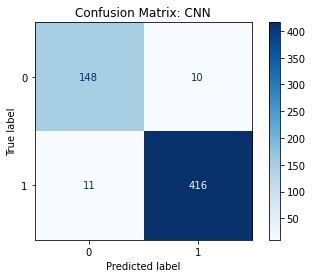

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       158
           1       0.98      0.97      0.98       427

    accuracy                           0.96       585
   macro avg       0.95      0.96      0.95       585
weighted avg       0.96      0.96      0.96       585



In [44]:
p_labels = pred_labels(preds,.5)

test_labels = test_generator.labels

cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: CNN')
plt.show()

print(classification_report(test_labels, p_labels))

From the results we can see that our model is fairly good at predicting both the majority and minority classes. For this problem we chose to focus on the precision metric. This is because properly diagnosing pneumonia is very important- letting someone who has pneumonia go untreated can be fatal, and treating someone for pneumonia when they don't have the illness, of course, is not optimal for many reasons.

### **Faster Model**

For this mode chose to have a smaller number of layers and convolutions in order to see how powerful the models predictive power would be with a simpler structure. This models predictive power is about the same as our baseline model, and it marginally does better at predicting the minority class. 

In [ ]:
# Fast model
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',padding='same',
                        input_shape=(256,256,1 )))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
# loading in the model
model = models.load_model('faster_model')

In [34]:
preds = model.predict(test_generator)

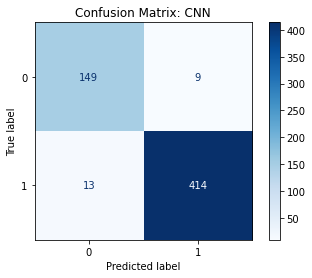

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       158
           1       0.98      0.97      0.97       427

    accuracy                           0.96       585
   macro avg       0.95      0.96      0.95       585
weighted avg       0.96      0.96      0.96       585



In [35]:
p_labels = pred_labels(preds,.5)

test_labels = test_generator.labels

cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: CNN')
plt.show()

print(classification_report(test_labels, p_labels))

The predictive power of this model is slightly weaker in comparison to our baseline. 

### **Final Model - Best Model**

Our final model is the most complex. It initially had double the layers and took double the amount of time to run. We wanted to see how it would run with less layers, and it preformed just as well. We were able to save some time running the model by doing this. 

In [ ]:
# Final model
# We chose to have our number of convolutions to move in ascending order 
#  until we reach to 256, the the number of convolutions begin to decrease 


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',
                        input_shape=(256 ,256, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(layers.Dropout(.2))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

In [4]:
# Loading in our best model
model = models.load_model('best_model')

In [9]:
preds = model.predict(test_generator)

In [13]:
p_labels = pred_labels(preds,.5)

In [11]:
test_labels = test_generator.labels

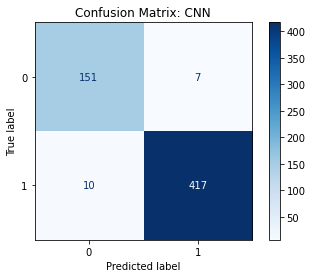

In [14]:
cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: CNN')
plt.show()

In [29]:
print(classification_report(test_labels, p_labels))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       158
           1       0.98      0.98      0.98       427

    accuracy                           0.97       585
   macro avg       0.96      0.97      0.96       585
weighted avg       0.97      0.97      0.97       585



This model preforms the best when it comes to predicting both the minority and majority class, and for this reason we chose this to be our final model. 